 *HW7*

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [21]:
%cd "C:\Users\Mahdie_Behjat\Desktop\Uni_Courses\ImageProcessing\TADocs\HW7"

C:\Users\Mahdie_Behjat\Desktop\Uni_Courses\ImageProcessing\TADocs\HW7


In [22]:
pwd

'C:\\Users\\Mahdie_Behjat\\Desktop\\Uni_Courses\\ImageProcessing\\TADocs\\HW7'

#*Q4*

Sobel

In [46]:
def modifiedSobelDetector(image):
  #define Sobel filters
  Gx = np.array([[1,0,-1] , [2,0,-2] , [1,0,-1]])
  Gy = np.array([[1,2,1] , [0,0,0] , [-1,-2,-1]])

  h , w = image.shape

  kernel_h = 3
  kernel_w = 3
  kernel_half = 1

  sobel_filtered_image = np.zeros(shape=(h,w))
  image = np.pad(array= image, pad_width=(kernel_h//2 , kernel_w//2), mode='constant', constant_values=(0,0))
  # Now sweep the image in both x and y directions and compute the output#
  for i in range(kernel_half , h-1):
    for j in range(kernel_half , w-1):
      cover_area = image[i - kernel_half: i + kernel_half + 1, j - kernel_half: j + kernel_half + 1]
      gx = np.sum(np.multiply(Gx , cover_area))
      gy = np.sum(np.multiply(Gy , cover_area))
      sobel_filtered_image[i-kernel_half , j-kernel_half] = np.sqrt(gx ** 2 + gy ** 2)


  maximum_gradient = np.max(sobel_filtered_image)
  threshold = 0.3 * maximum_gradient
  sobel_filtered_image[sobel_filtered_image<threshold] = 0
  sobel_filtered_image[sobel_filtered_image>= threshold] = 1

  return sobel_filtered_image

<Figure size 432x288 with 0 Axes>

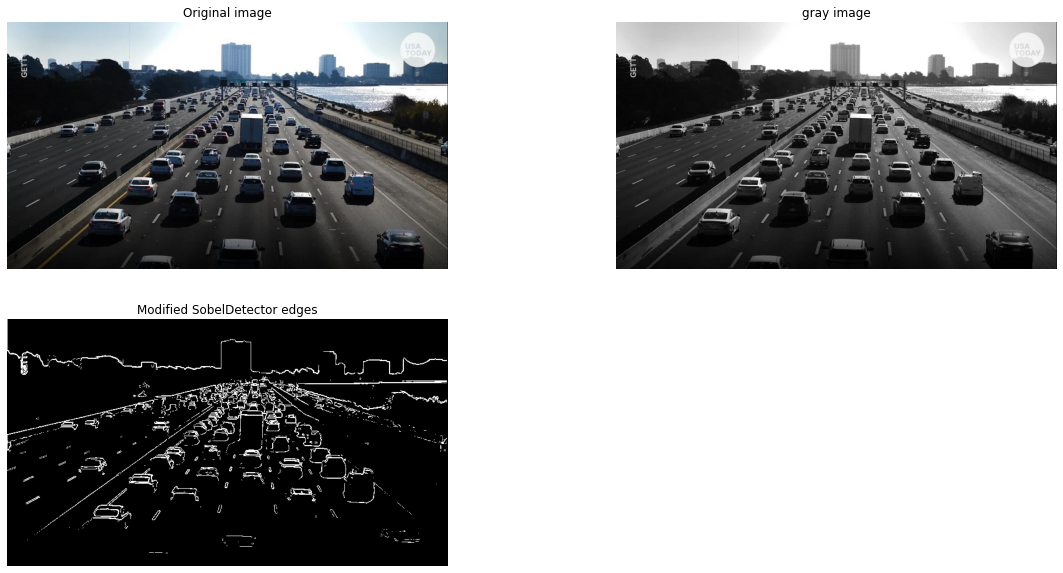

In [47]:
# show result
image = cv2.imread("traffic.jpg")
image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image , cv2.COLOR_RGB2GRAY)
sobel_output = modifiedSobelDetector(gray_image)
# This command will display the grayscale image alongside the original image
plt.gray()
fig = plt.figure(figsize = (20,10))
cols = 2
rows = 2
fig.add_subplot(rows , cols , 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows , cols , 2)
plt.imshow(gray_image)
plt.axis('off')
plt.title("gray image")

fig.add_subplot(rows , cols , 3)
plt.imshow(sobel_output)
plt.axis('off')
plt.title("Modified SobelDetector edges")

plt.show()

Canny

In [49]:
def smoothing(img):
  output = img.copy()

  output = cv2.GaussianBlur(img, (5, 5), 1.3)

  return output

In [50]:
def comput_gradient(img):

  mag = np.zeros_like(img)
  angle = np.zeros_like(img)

  # we used library here#
  gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
  gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
     
  mag = np.sqrt(gx **2 + gy**2)
  angle = np.arctan2(gy,gx) * 180 / np.pi

  return mag,angle

In [51]:
def NMS(mag,angle):

  ang = angle
  height, width = mag.shape
      
    
  for i_x in range(width):
        for i_y in range(height):  
            grad_ang = abs(ang[i_y, i_x])
            if grad_ang<= 22.5:
                neighb_indexes = [[i_x-1, i_y],[i_x + 1, i_y]]
                
             
   
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_indexes = [[i_x-1, i_y-1],[i_x + 1, i_y + 1]]
             

            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_indexes = [[i_x, i_y-1],[i_x, i_y + 1]]
                
             
  
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_indexes = [[i_x-1, i_y + 1],[i_x + 1, i_y-1]]
                
             
            elif grad_ang>(22.5 + 135) and grad_ang<=180:
                neighb_indexes = [[i_x-1, i_y],[i_x + 1, i_y]]
                
              
            # Non-maximum suppression step
            if width>neighb_indexes[0][0]>= 0 and height>neighb_indexes[0][1]>= 0:
                if mag[i_y, i_x]<mag[neighb_indexes[0][1], neighb_indexes[0][0]]:
                    mag[i_y, i_x]= 0
                    continue
  
            if width>neighb_indexes[1][0]>= 0 and height>neighb_indexes[1][1]>= 0:
                if mag[i_y, i_x]<mag[neighb_indexes[1][1], neighb_indexes[1][0]]:
                    mag[i_y, i_x]= 0

  output = mag

  return output

In [52]:
def CheckConnection(img,x,y):
    for i in range(-1,2):
        for j in range(-1,2):
            if img.shape[1]>x + j>=0 and img.shape[0]>y + i>=0:
                if img[y + i,x + j] == 125:
                    img[y + i,x + j] = 255
                    CheckConnection(img,x+j,y+i)

In [53]:
def hysteresis_threshold(edges,min_th,max_th):

  weak_ids = np.zeros_like(edges)
  strong_ids = np.zeros_like(edges)             
  ids = np.zeros_like(edges)
      
   
  for i_x in range(edges.shape[1]):
      for i_y in range(edges.shape[0]):
             
          grad_mag = edges[i_y, i_x]
             
          if grad_mag<min_th:
              ids[i_y, i_x]= 0
          elif max_th>grad_mag>= min_th:
              ids[i_y, i_x]= 125
          else:
              ids[i_y, i_x]= 255

  Ys,Xs = np.where(ids==255)
  for i in range(len(Ys)):
    CheckConnection(ids,Xs[i],Ys[i])
  Ys,Xs = np.where(ids==125)
  ids[Ys,Xs] = 0
  output = ids

  return output

In [54]:
def canny(img,min_th,max_th):
  smooth_img = smoothing(img)
  mag,angle = comput_gradient(smooth_img)
  edges = NMS(mag,angle)
  final_edges = hysteresis_threshold(edges,min_th,max_th)
  return final_edges

Text(0.5, 1.0, 'custom Canny')

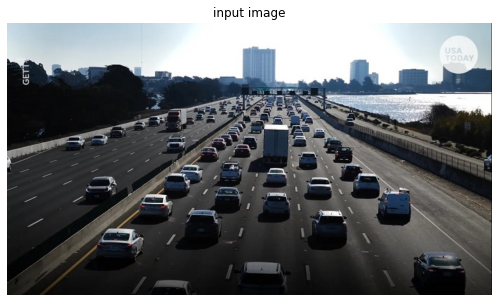

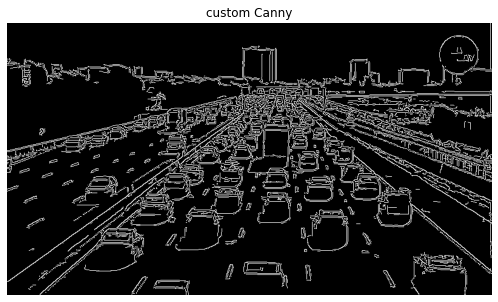

In [58]:
img = img = cv2.imread('traffic.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
image_g = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
min_th,max_th = 30,60
edges = canny(image_g,min_th,max_th)

plt.figure(figsize=(10,5))
plt.imshow(img)
plt.axis('off')
plt.title('input image')
plt.figure(figsize=(10,5))
plt.imshow(edges,cmap='gray')
plt.axis('off')
plt.title('custom Canny')